/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading and processing data in parallel...
  Completed: tas - historical
  Completed: hurs - historical
  Completed: sfcWind - historical
  Completed: pr - historical
  Completed: tas - ssp126
  Completed: tas - ssp245
  Completed: tas - ssp585
  Completed: sfcWind - ssp126
  Completed: sfcWind - ssp585
  Completed: hurs - ssp585
  Completed: sfcWind - ssp245
  Completed: hurs - ssp245
  Completed: hurs - ssp126
  Completed: pr - ssp245
  Completed: pr - ssp585
  Completed: pr - ssp126
All data loaded and processed!
Creating plots...


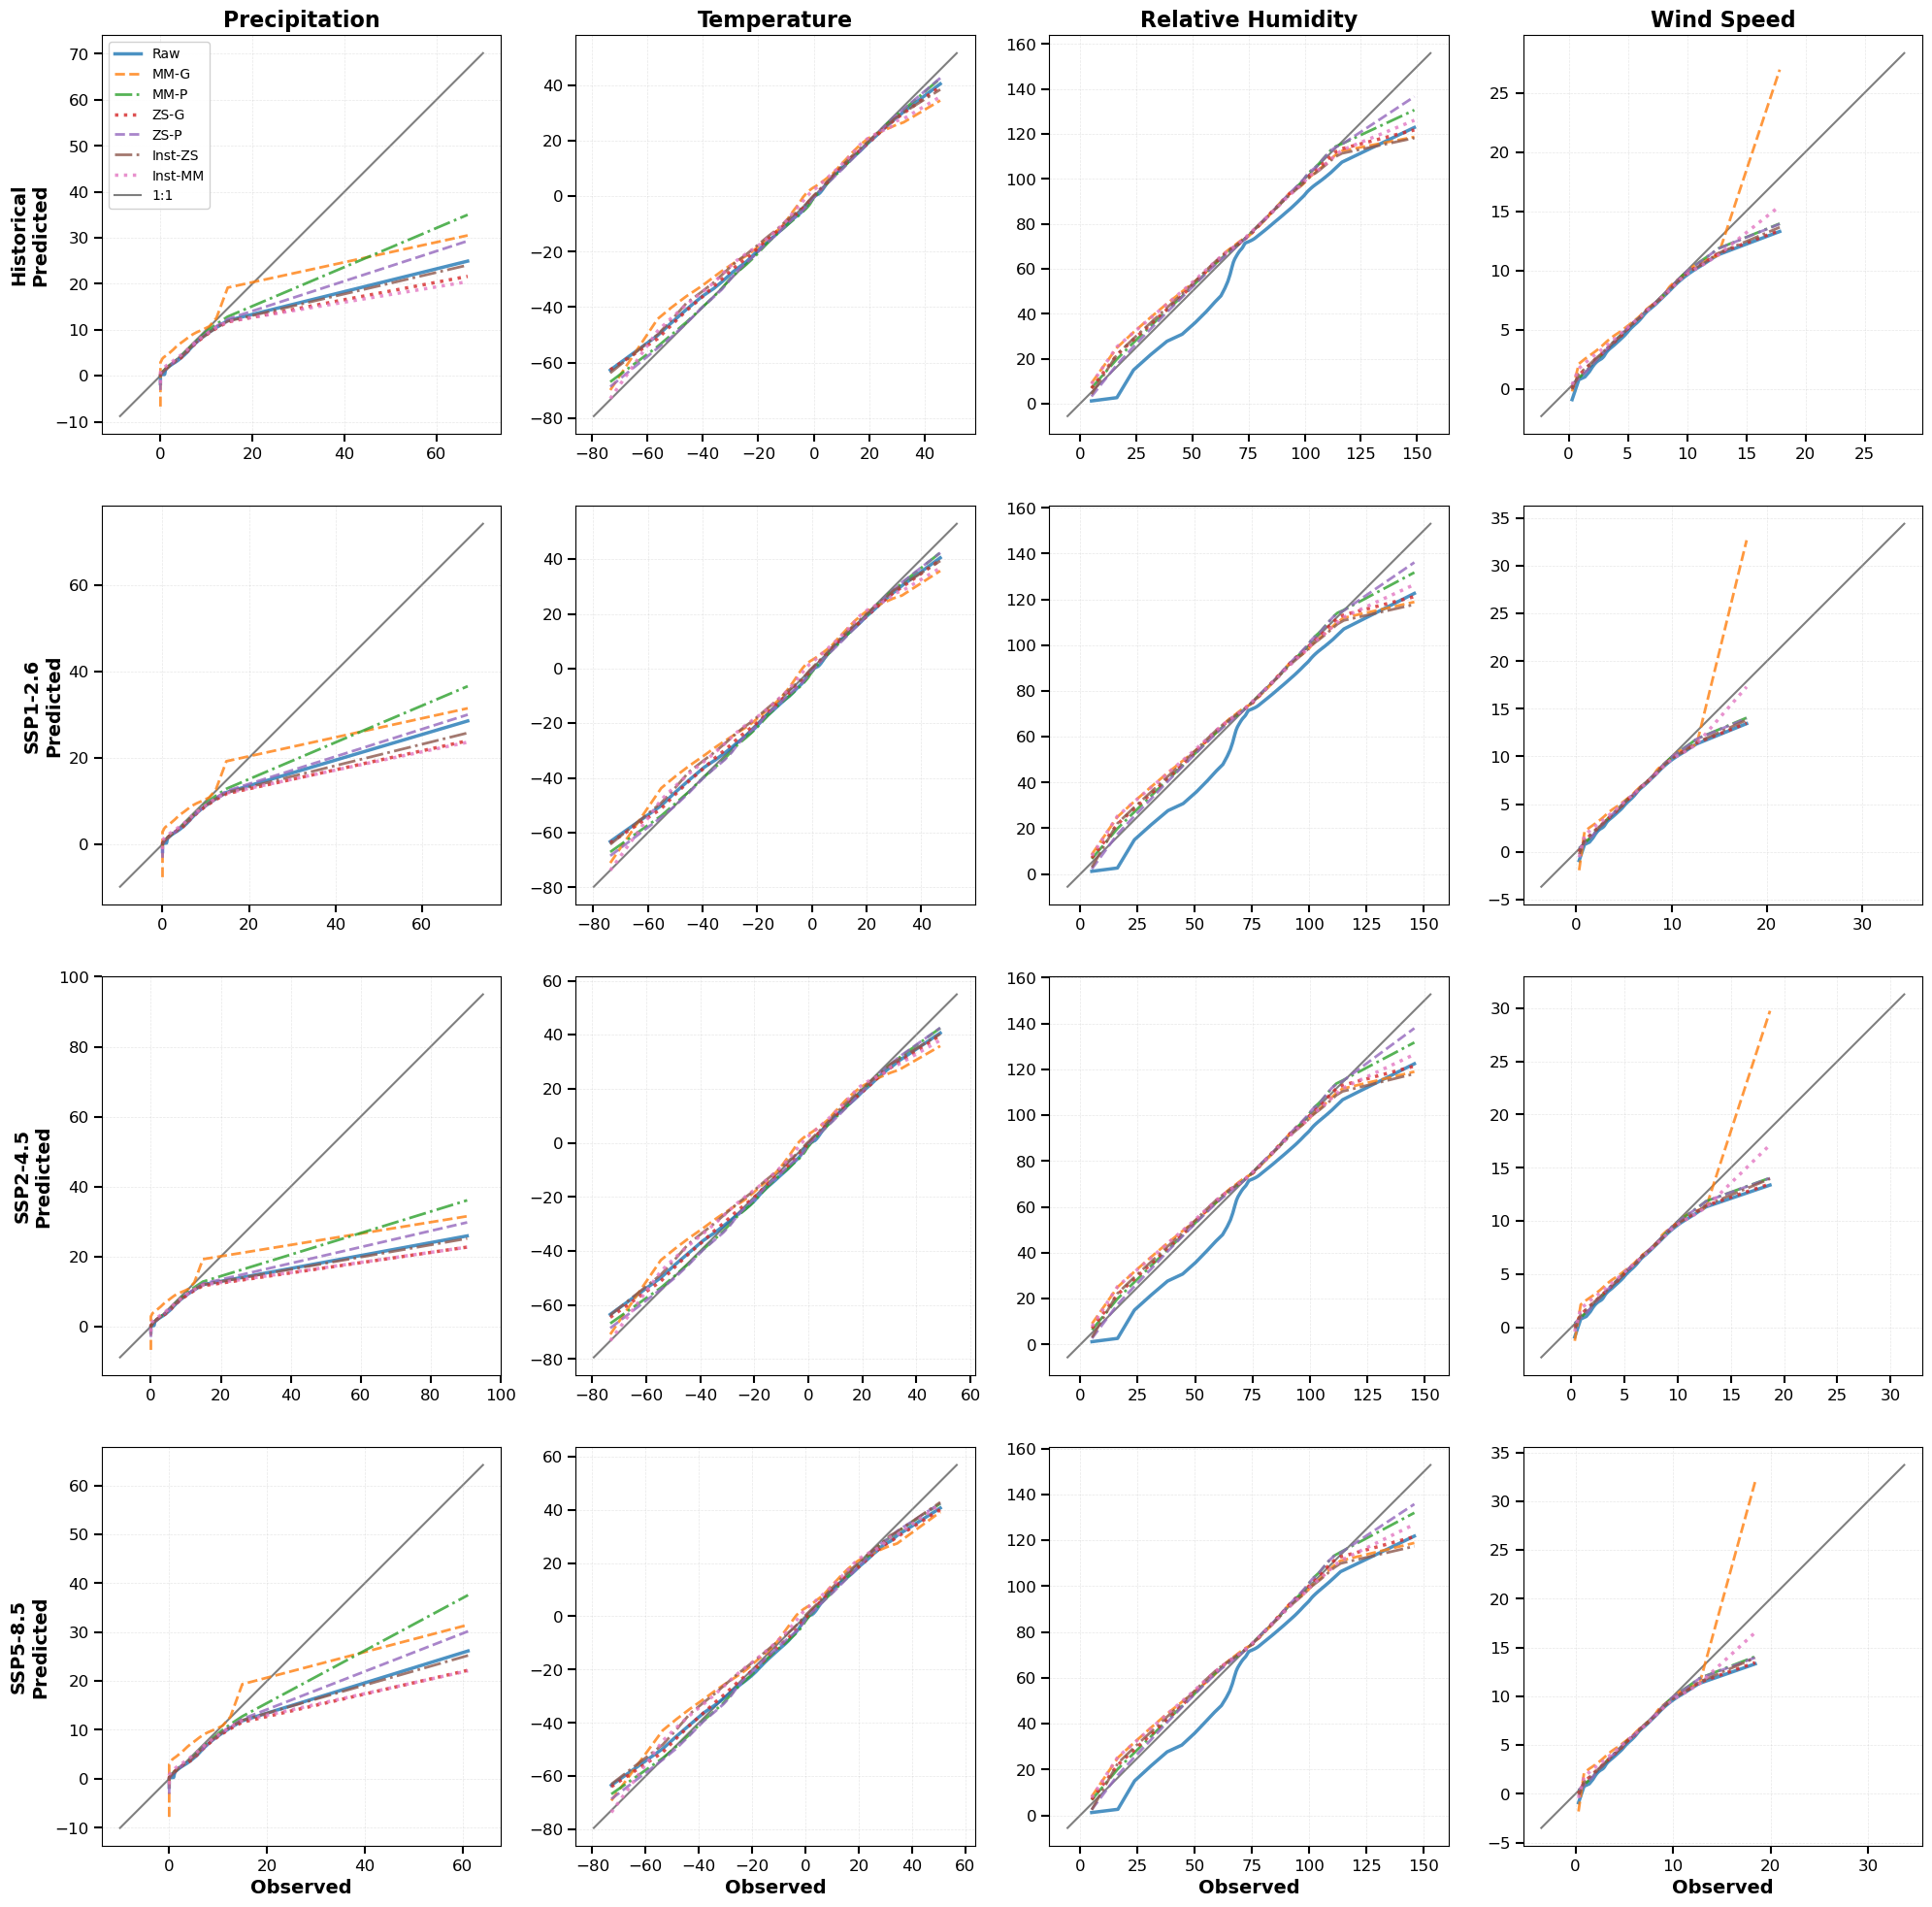

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
figures_dir = Path("../Figures")

variables = ['pr', 'tas', 'hurs', 'sfcWind']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']
normalizations = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                  'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Normalization labels for plotting
norm_labels = {
    'none': 'Raw',
    'minmax_global': 'MM-G',
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS',
    'instance_minmax': 'Inst-MM'
}

# Variable names for titles
var_names = {
    'pr': 'Precipitation',
    'tas': 'Temperature',
    'hurs': 'Relative Humidity',
    'sfcWind': 'Wind Speed'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Colors and line styles for better distinguishability
norm_styles = {
    'none': {'color': '#1f77b4', 'linestyle': '-', 'linewidth': 2.5},
    'minmax_global': {'color': '#ff7f0e', 'linestyle': '--', 'linewidth': 2},
    'minmax_pixel': {'color': '#2ca02c', 'linestyle': '-.', 'linewidth': 2},
    'zscore_global': {'color': '#d62728', 'linestyle': ':', 'linewidth': 2.5},
    'zscore_pixel': {'color': '#9467bd', 'linestyle': '--', 'linewidth': 2},
    'instance_zscore': {'color': '#8c564b', 'linestyle': '-.', 'linewidth': 2},
    'instance_minmax': {'color': '#e377c2', 'linestyle': ':', 'linewidth': 2.5}
}

# ----------------------------
# Optimized Functions
# ----------------------------
def flatten_spatial_data_fast(data):
    """Vectorized flattening - much faster than previous version."""
    # Use numpy's flatten and boolean indexing in one step
    flat = data.values.ravel()
    return flat[~np.isnan(flat)]

def compute_qq_quantiles_vectorized(data1, data2, n_quantiles=100):
    """Vectorized quantile computation."""
    quantiles = np.linspace(0, 1, n_quantiles)
    # np.quantile can handle multiple quantiles at once - already vectorized
    q1 = np.quantile(data1, quantiles)
    q2 = np.quantile(data2, quantiles)
    return q1, q2

def process_single_file(var, scenario, normalizations, results_dir):
    """Process one file and return all quantile data for that var-scenario combo."""
    results_file = results_dir / f"{var}_evaluation_{scenario}.nc"
    
    try:
        # Load dataset with dask for lazy loading
        ds = xr.open_dataset(results_file, chunks='auto')
        
        # Flatten ground truth once
        gt_flat = flatten_spatial_data_fast(ds['groundtruth'])
        
        # Pre-compute quantile positions
        quantile_positions = np.linspace(0, 1, 100)
        gt_quantiles = np.quantile(gt_flat, quantile_positions)
        
        # Process all normalizations for this file
        results = {'gt_quantiles': gt_quantiles}
        
        for norm in normalizations:
            pred_key = f'pred_{norm}'
            
            if pred_key in ds:
                pred_flat = flatten_spatial_data_fast(ds[pred_key])
                pred_quantiles = np.quantile(pred_flat, quantile_positions)
                results[norm] = pred_quantiles
            else:
                results[norm] = None
        
        ds.close()
        return (var, scenario, results)
        
    except Exception as e:
        print(f"Error processing {var}_{scenario}: {e}")
        return (var, scenario, None)

# ----------------------------
# Parallel data loading and processing
# ----------------------------
print("Loading and processing data in parallel...")

# Create all combinations
tasks = [(var, scenario) for var in variables for scenario in scenarios]

# Use parallel processing to load and compute quantiles
all_results = {}
n_cores = max(1, mp.cpu_count() - 1)  # Leave one core free

with ProcessPoolExecutor(max_workers=n_cores) as executor:
    # Submit all tasks
    futures = {
        executor.submit(process_single_file, var, scenario, normalizations, results_dir): (var, scenario)
        for var, scenario in tasks
    }
    
    # Collect results as they complete
    for future in as_completed(futures):
        var, scenario, results = future.result()
        
        if var not in all_results:
            all_results[var] = {}
        all_results[var][scenario] = results
        
        print(f"  Completed: {var} - {scenario}")

print("All data loaded and processed!")

# ----------------------------
# Create Q-Q plots (fast plotting)
# ----------------------------
print("Creating plots...")

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for row_idx, scenario in enumerate(scenarios):
    for col_idx, var in enumerate(variables):
        ax = axes[row_idx, col_idx]
        
        results = all_results.get(var, {}).get(scenario)
        
        if results is None:
            ax.text(0.5, 0.5, 'Data not available', 
                   transform=ax.transAxes, ha='center', va='center')
            continue
        
        gt_quantiles = results['gt_quantiles']
        
        # Plot all normalizations
        for norm in normalizations:
            pred_quantiles = results.get(norm)
            
            if pred_quantiles is None:
                continue
            
            # Plot with distinct style
            style = norm_styles[norm]
            ax.plot(gt_quantiles, pred_quantiles,
                   color=style['color'],
                   linestyle=style['linestyle'],
                   linewidth=style['linewidth'],
                   label=norm_labels[norm],
                   alpha=0.8)
        
        # Add 1:1 reference line
        lims = [
            min(ax.get_xlim()[0], ax.get_ylim()[0]),
            max(ax.get_xlim()[1], ax.get_ylim()[1])
        ]
        ax.plot(lims, lims, 'k-', alpha=0.5, linewidth=1.5, zorder=0, label='1:1')
        
        # Set equal aspect ratio
        ax.set_aspect('equal', adjustable='box')
        
        # Labels
        if col_idx == 0:
            ax.set_ylabel(f'{scenario_labels[scenario]}\nPredicted', 
                        fontsize=14, fontweight='bold')
        if row_idx == 3:
            ax.set_xlabel('Observed', fontsize=14, fontweight='bold')
        
        # Title only on top row
        if row_idx == 0:
            ax.set_title(var_names[var], fontsize=16, fontweight='bold')
        
        # Legend only in first panel
        if row_idx == 0 and col_idx == 0:
            ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
        
        # Grid
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Increase tick size
        ax.tick_params(axis='both', which='major', labelsize=12, 
                      length=6, width=1.5)

plt.tight_layout()

# # Save figure
# output_file = figures_dir / "02_qq_plots_all_scenarios.png"
# plt.savefig(output_file, dpi=300, bbox_inches='tight')
# print(f"\nFigure saved to: {output_file}")